In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageFilter
import glob
from sklearn.utils import shuffle

In [29]:
print('Tensorflow version: ', tf.__version__)
print('Numpy version: ', np.__version__)

Tensorflow version:  2.3.0
Numpy version:  1.21.5


# Table of contents
#### Part A: No image augmentation and basic prediction model
#### Part B: With Image augmentation and basic prediction model
#### Part C: No image augmentation, and expanded model 
#### Part D: Image augmentation and expanded model
#### Conclusion
#### Part E: (Experimental) Transfer learning with Resnet50

# Part A: No image augmentation, basic prediction model
All training images are used without alteration. A minimal model will be used for prediction. The accuracy score will be used as a baseline/control. 

In [30]:
# path to train and test image files
train_img_dir = "./train/"
test_img_dir = "./test/"

# category as well as name of image files
image_types = ["apple","orange","banana","mixed"]

# image size after resizing (higher sizes takes more time but are more accurate)
IMG_MAX_SIZE = 64

# epoch value
EPOCH_MAX = 50

# stop at valuation accuracy
VAL_ACCURACY_THRESHOLD = 0.95

#### All methods for image augmentation and model creation are written here

In [31]:
# return all files in the directory in a dictionary seperated by their category
def get_files_in_dir(img_dir, image_types):
    file_path_arr = {}
    for img_type in image_types:
        file_path_arr.update( {img_type: glob.glob(img_dir+img_type+"*")} )
    
    return file_path_arr
    




# remove offending images from dictionary (expanded model)
def remove_from_dictionary(file_path_arr,str_match):
    for key in file_path_arr:
        max = len(file_path_arr[key])
        for i in  range(0,max):
            my_str = str(file_path_arr[key][i])
            if str_match in my_str:
                del file_path_arr[key][i]
                print("Removed: ",key," ",i," ",file_path_arr[key][i])
                return





# convert image to 3 layer RGB from RGBA or other formats, then resize the images
def convert_to_RGB_and_resize(img):
    img_new = Image.new("RGB",img.size, (255,255,255))
    img_new.paste(img,None)
    img_tiny = img_new.resize((IMG_MAX_SIZE, IMG_MAX_SIZE))
    return img_tiny




# remove the color green and whitish backgrounds (expanded model)
def fix_image_color(img):
    pixdata = img.load()
    for y in range(img.size[1]):
        for x in range(img.size[0]):
                r, g, b = img.getpixel((x, y))
                if (r < 80 and g < 255 and b < 255):
                    pixdata[x, y] = (0, 0, 0)
                if (r > 220 and g > 220 and b > 220):
                    pixdata[x, y] = (0, 0, 0)
    #img2 = img.filter(ImageFilter.GaussianBlur(radius=2))
    return img




# read a file and process it and return the file contents
def read_single_file(img_path):
    img_raw = Image.open(img_path)
    img_tiny = convert_to_RGB_and_resize(img_raw)
    img_tiny_fixed = fix_image_color(img_tiny)
    return img_tiny_fixed




# zoom in the photo by scale variable (expanded model)
def img_scaled_inwards(img_tiny, scale=1.2):
    new_size = int(img_tiny.size[0] * scale)
    img_upscaled = img_tiny.resize((new_size,new_size))
    crop_pad = int( (img_upscaled.size[0] - img_tiny.size[0] ) / 2)

    img_tiny_new = img_upscaled.crop((crop_pad,crop_pad,img_upscaled.size[0]-crop_pad,img_upscaled.size[1]-crop_pad))
    return img_tiny_new.resize((IMG_MAX_SIZE,IMG_MAX_SIZE))






# generate 1 hot encoding for y_data
def get_y_datas(fruit_type,image_types):
    y_value = [ 0, 0, 0, 0]
    for i in range(0,4):
        if( fruit_type == image_types[i]):
            y_value[i] = 1
    return np.asarray(y_value)





# increase sample size by playing with contrast, color, sharpness and rotation (expanded model)
def image_augmentation(img_tiny, y_data):
    img_0 = np.asarray( img_tiny )
    # Rotate image
    # Fix image color and contrast
    img_filter = ImageEnhance.Contrast(img_tiny)
    img_e = img_filter.enhance(1.2)
    img_1 = np.asarray( img_e )

    img_filter = ImageEnhance.Contrast(img_tiny)
    img_e = img_filter.enhance(0.8)
    img_2 = np.asarray( img_e )

    img_filter = ImageEnhance.Color(img_tiny)
    img_e = img_filter.enhance(1.5)
    img_3 = np.asarray( img_e )

    img_filter = ImageEnhance.Color(img_tiny)
    img_e = img_filter.enhance(0.8)
    img_4 = np.asarray( img_e )

    img_filter = ImageEnhance.Contrast(img_tiny)
    img_e = img_filter.enhance(1.2)
    img_filter = ImageEnhance.Color(img_e)
    img_e = img_filter.enhance(1.5)
    img_5 = np.asarray( img_e )

    img_filter = ImageEnhance.Sharpness(img_tiny)
    img_e = img_filter.enhance(0.5)
    img_6 = np.asarray( img_e )

    img_7 = np.asarray( img_tiny.transpose(Image.FLIP_TOP_BOTTOM) )
    img_8 = np.asarray( img_tiny.transpose(Image.FLIP_LEFT_RIGHT) )
    img_9 = np.asarray( img_scaled_inwards(img_tiny) )

    x_return = np.concatenate( (img_0, img_1, img_2, img_3, img_4, img_5,  img_6,  img_7,  img_8,  img_9 ) )
    y_return = np.concatenate( (y_data, y_data, y_data, y_data, y_data, y_data, y_data, y_data, y_data, y_data ) )
    return x_return, y_return




# For 'mixed fruits' dataset, we expand its original dataset(~20 images) by 4 times to match other 
# categories(~70 images). Evenly balancing the dataset might improve its prediction ability. (expanded model)
def image_augmentation_mixed(img_tiny, y_data): 
    img_1 = img_tiny.rotate(30)
    img_2 = img_tiny.rotate(60)
    img_3 = img_tiny.rotate(90)
    
    x_return_0, y_return_0 = image_augmentation(img_tiny, y_data)
    x_return_1, y_return_1 = image_augmentation(img_1, y_data)
    x_return_2, y_return_2 = image_augmentation(img_2, y_data)      
    x_return_3, y_return_3 = image_augmentation(img_3, y_data)

    x_return = np.concatenate(( x_return_0, x_return_1, x_return_2 , x_return_3))
    y_return = np.concatenate(( y_return_0, y_return_1, y_return_2 , y_return_3))
    return x_return, y_return




# read file paths provided in dictionary into a numpy array for CNN. 
# if img_aug is False, no image augmentation is done and only the original images are used for training and testing. 
def read_files_into_array(file_path_arr,image_types,img_aug=False):
    x_data = None
    y_data = None
    p_data = None
    for key in file_path_arr:
        for img_path in file_path_arr[key]:
            img_tiny = read_single_file(img_path)
            y_data_1 =  get_y_datas(key, image_types)
            
            # if mixed, generate more data
            if(img_aug==True):
                if(key=='mixed'): 
                    x_data_1, y_data_1 = image_augmentation_mixed(img_tiny, y_data_1)
                else: 
                    x_data_1, y_data_1 = image_augmentation(img_tiny, y_data_1)
            else:
                x_data_1 = np.asarray(img_tiny)
            
            # join our data to main np array
            if( x_data is None ):
                x_data = x_data_1
                y_data = y_data_1
                p_data = [img_path]
            else:
                x_data = np.concatenate( (x_data, x_data_1) )
                y_data = np.concatenate( (y_data, y_data_1) )
                p_data = np.concatenate( (p_data, [img_path]) )
    return x_data, y_data, p_data


# Minimal model for prediction.
def create_model_basic():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(IMG_MAX_SIZE, IMG_MAX_SIZE, 3)),
        tf.keras.layers.AveragePooling2D((2,2), strides=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=4, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Create a CNN model
def create_model_expanded():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu",input_shape=(IMG_MAX_SIZE, IMG_MAX_SIZE, 3)),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),

        tf.keras.layers.Conv2D(32, (3,3), padding='same', activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),

        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),

        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),

        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(128, (3,3), padding='same', activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2), strides=2),

        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(units=128),
        
        tf.keras.layers.Dense(128, activation="relu"),

        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4, activation="softmax")
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model





# Implement callback function to stop training
class stop_model_training_class(tf.keras.callbacks.Callback):  
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') >= VAL_ACCURACY_THRESHOLD):   
            print("\nReached ",VAL_ACCURACY_THRESHOLD," valuation accuracy, so stopping training!!")   
            self.model.stop_training = True






# roundup the data array
def round_out(data):
    str_out = "["
    for x in data:
        str_out += str( round(x,3) ) + "  "
    return str_out + "]"






# show actual vs predicted data
def show_diffs(model, x_test, y_test, p_test):
    predictions = model.predict(x=x_test)

    print('list of wrongly predicted images:')
    for i in np.arange(len(predictions)):
        for j in np.arange(4): 
            if ((y_test[i][j] == 1) and (predictions[i][j] < 0.5)): 
               print('D: {}'.format(p_test[i]))
    
    print('Model scoring vs ground truth')
    for i in np.arange(len(predictions)):
        print('D: {}, A: {}, P: {}'.format(p_test[i], y_test[i], round_out(predictions[i]) ))






# plot loss vs accuracy curves
def plot_loss(hist):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

    ax[0,0].plot(hist.history['loss'])
    ax[0,0].set_xlabel('Epochs')
    ax[0,0].set_ylabel('Loss')
    ax[0,0].set_title('Loss Curve')
    ax[0,0].grid(color='g', linestyle='-', linewidth=0.2)

    ax[0,1].plot(hist.history['accuracy'])
    ax[0,1].set_xlabel('Epochs')
    ax[0,1].set_ylabel('Accuracy')
    ax[0,1].set_title('Accuracy Curve')
    ax[0,1].grid(color='g', linestyle='-', linewidth=0.2)

    ax[1,0].plot(hist.history['val_loss'])
    ax[1,0].set_xlabel('Epochs')
    ax[1,0].set_ylabel('Validation Loss')
    ax[1,0].set_title('Validation Loss Curve')
    ax[1,0].grid(color='g', linestyle='-', linewidth=0.2)

    ax[1,1].plot(hist.history['val_accuracy'])
    ax[1,1].hlines(0.95,0,EPOCH_MAX, colors="r",linestyles="dashed", linewidth=1)
    ax[1,1].hlines(0.90,0,EPOCH_MAX, colors="r",linestyles="dashed", linewidth=1)
    ax[1,1].set_xlabel('Epochs')
    ax[1,1].set_ylabel('Validation Accuracy')
    ax[1,1].set_title('Validation Accuracy Curve')
    ax[1,1].grid(color='g', linestyle='-', linewidth=0.2)

    fig.tight_layout(pad=3.0)

    plt.show()

#### Preparing the dataset

In [32]:
# get list of training files
file_path_arr = get_files_in_dir(train_img_dir, image_types)

# show how many of each type we have
print('Files of each type used for training: ')
for key in file_path_arr:
    print(key, "->", len(file_path_arr[key]))
x_train, y_train, _ = read_files_into_array(file_path_arr,image_types,img_aug=False)
x_train = x_train.reshape(-1,IMG_MAX_SIZE,IMG_MAX_SIZE,3)
y_train = y_train.reshape(-1,4)
# get test file list

print('Files of each type used for testing: ')
file_path_arr_2 = get_files_in_dir(test_img_dir, image_types)
# show how many of each type we have
for key in file_path_arr_2:
    print(key, "->", len(file_path_arr_2[key]))
# generate x and y test data as well as the file paths
x_test, y_test, p_test = read_files_into_array(file_path_arr_2,image_types)
# reshape x and y test data
x_test = x_test.reshape(-1,IMG_MAX_SIZE,IMG_MAX_SIZE,3)
y_test = y_test.reshape(-1,4)

Files of each type used for training: 
apple -> 75
orange -> 72
banana -> 73
mixed -> 20
Files of each type used for testing: 
apple -> 19
orange -> 18
banana -> 18
mixed -> 5


In [33]:
#checking input and output shapes
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(240, 64, 64, 3)
(240, 4)
(60, 64, 64, 3)
(60, 4)


Minimal model will be used first

In [34]:
model = create_model_basic()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
average_pooling2d_3 (Average (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 508036    
Total params: 508,932
Trainable params: 508,932
Non-trainable params: 0
_________________________________________________________________


Shuffle dataset for more even training. 
For each epoch, the model will be used to for evaluation with the testing data 

In [35]:
x_train, y_train = shuffle(x_train,y_train,random_state=9)

# train the model then run the test at each to see accuracy
history = model.fit(x=x_train/255, y=y_train, epochs=EPOCH_MAX, verbose=1, validation_data=(x_test/255,y_test))

Epoch 1/50
8/8 [==============================] - 1s 76ms/step - loss: 2.5840 - accuracy: 0.3958 - val_loss: 2.4775 - val_accuracy: 0.4333
Epoch 2/50
8/8 [==============================] - 0s 58ms/step - loss: 1.0454 - accuracy: 0.6542 - val_loss: 1.2086 - val_accuracy: 0.6167
Epoch 3/50
8/8 [==============================] - 1s 68ms/step - loss: 0.5222 - accuracy: 0.8333 - val_loss: 0.7252 - val_accuracy: 0.7000
Epoch 4/50
8/8 [==============================] - 0s 62ms/step - loss: 0.2012 - accuracy: 0.9333 - val_loss: 0.6367 - val_accuracy: 0.8000
Epoch 5/50
8/8 [==============================] - 0s 55ms/step - loss: 0.1188 - accuracy: 0.9708 - val_loss: 0.6233 - val_accuracy: 0.8333
Epoch 6/50
8/8 [==============================] - 0s 52ms/step - loss: 0.0655 - accuracy: 0.9958 - val_loss: 0.6131 - val_accuracy: 0.8667
Epoch 7/50
8/8 [==============================] - 0s 53ms/step - loss: 0.0361 - accuracy: 1.0000 - val_loss: 0.6148 - val_accuracy: 0.8500
Epoch 8/50
8/8 [===========

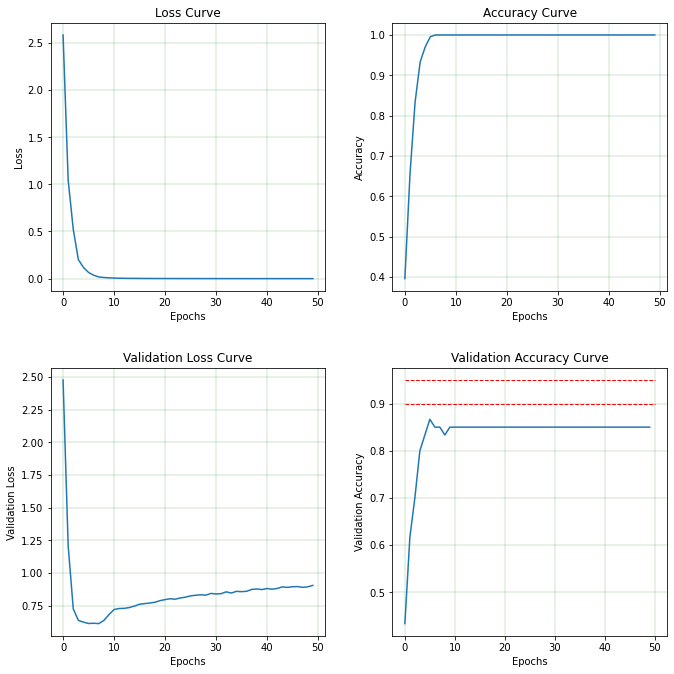

In [36]:
# plot loss and accuracy curves (disabled as well)
plot_loss(history)

In [37]:
show_diffs(model, x_test/255, y_test, p_test)

list of wrongly predicted images:
D: ./test\apple_86.jpg
D: ./test\orange_77.jpg
D: ./test\orange_90.jpg
D: ./test\banana_88.jpg
D: ./test\mixed_21.jpg
D: ./test\mixed_22.jpg
D: ./test\mixed_23.jpg
D: ./test\mixed_24.jpg
D: ./test\mixed_25.jpg
Model scoring vs ground truth
D: ./test\apple_77.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_78.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_79.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_80.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_81.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_82.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_83.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_84.jpg, A: [1 0 0 0], P: [0.816  0.152  0.023  0.01  ]
D: ./test\apple_85.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_86.jpg, A: [1 0 0 0], P: [0.202  0.001  0.785  0.012  ]
D: ./test\apple_87.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./te

### Observation: 
It appears that the model prediction score peaked after 5 epoches, which might suggest that the model learning saturation. Infact, overfitting to the training data seems to occur, as seen from the raise in validation loss and fall of validation accuracy of test data. 

The model wrongly predicted a mixture of all classes of images.

Test data accuracy score averaged around 85%. 

# Part B: Image augmentation and minimal model
#### The following measures will be done to improve the prediction score and learning process
1. Removing of wrongly labelled images 
1. Removing color from some backgrounds. (we do not wish the model to learn about the background)
1. Reinforcing contrast of colors, to emphasize on features
1. Balancing data of all classes by increasing mixed images 
1. Increase overall dataset size through image augmentation techniques such as: 
    - Transpose/Flipping
    - Rotation (Fruits are expected to be in all possible orientations)
    - Scaling (Fruits are of varying sizes, and can occupy any amount of the image)

* Minimal model will be used

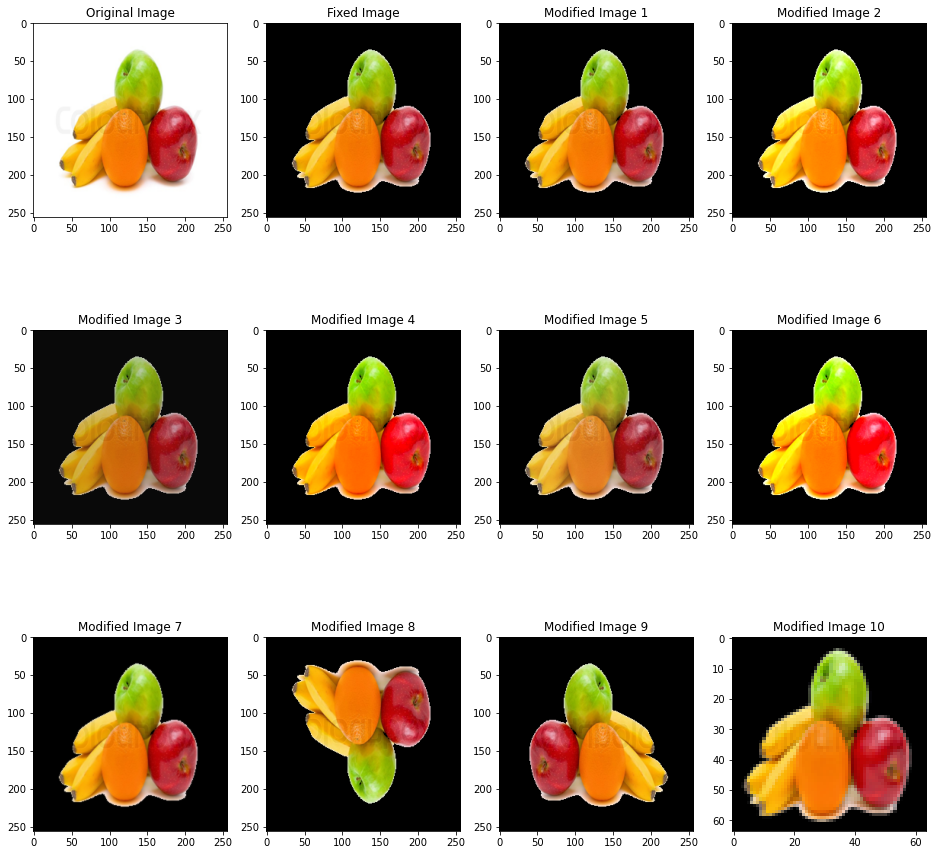

In [38]:
sample_image_path = "train/mixed_7.jpg"


img_raw = Image.open(sample_image_path).convert("RGB")
img_orginal = img_raw.resize((256,256))

img_raw = Image.open(sample_image_path).convert("RGB")
img_tiny = img_raw.resize((256,256))
img_tiny_fixed = fix_image_color(img_tiny)

img_0 = img_tiny_fixed

img_filter = ImageEnhance.Contrast(img_tiny_fixed)
img_e = img_filter.enhance(1.2)
img_1 = img_e

img_filter = ImageEnhance.Contrast(img_tiny_fixed)
img_e = img_filter.enhance(0.8)
img_2 = img_e

img_filter = ImageEnhance.Color(img_tiny_fixed)
img_e = img_filter.enhance(1.5)
img_3 = img_e

img_filter = ImageEnhance.Color(img_tiny_fixed)
img_e = img_filter.enhance(0.8)
img_4 = img_e

img_filter = ImageEnhance.Contrast(img_tiny_fixed)
img_e = img_filter.enhance(1.2)
img_filter = ImageEnhance.Color(img_e)
img_e = img_filter.enhance(1.5)
img_5 = img_e

img_filter = ImageEnhance.Sharpness(img_tiny_fixed)
img_e = img_filter.enhance(0.5)
img_6 = img_e

img_7 = img_tiny_fixed.transpose(Image.FLIP_TOP_BOTTOM)
img_8 = img_tiny_fixed.transpose(Image.FLIP_LEFT_RIGHT)
img_9 = img_scaled_inwards(img_tiny_fixed)


fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 16))

ax[0,0].set_title("Original Image")
ax[0,0].imshow(img_orginal)

ax[0,1].set_title("Fixed Image")
ax[0,1].imshow(img_tiny_fixed)

ax[0,2].set_title("Modified Image 1")
ax[0,2].imshow(img_0)

ax[0,3].set_title("Modified Image 2")
ax[0,3].imshow(img_1)


ax[1,0].set_title("Modified Image 3")
ax[1,0].imshow(img_2)

ax[1,1].set_title("Modified Image 4")
ax[1,1].imshow(img_3)

ax[1,2].set_title("Modified Image 5")
ax[1,2].imshow(img_4)

ax[1,3].set_title("Modified Image 6")
ax[1,3].imshow(img_5)


ax[2,0].set_title("Modified Image 7")
ax[2,0].imshow(img_6)

ax[2,1].set_title("Modified Image 8")
ax[2,1].imshow(img_7)

ax[2,2].set_title("Modified Image 9")
ax[2,2].imshow(img_8)

ax[2,3].set_title("Modified Image 10")
ax[2,3].imshow(img_9)

plt.show()

In [39]:
# list of offending images
skip_img_names = ["apple_11","apple_20","apple_36","apple_39",
                  "banana_35","banana_61",
                  "mixed_2","mixed_20",
                  "orange_11","orange_13","orange_35","orange_42"]

# remove offending images
for skip_name in skip_img_names:
     remove_from_dictionary(file_path_arr,skip_name)

# get list of training files
file_path_arr = get_files_in_dir(train_img_dir, image_types)

# show how many of each type we have
print('Files of each type used for training: ')
for key in file_path_arr:
    print(key, "->", len(file_path_arr[key]))
x_train, y_train, _ = read_files_into_array(file_path_arr,image_types,img_aug=True)
x_train = x_train.reshape(-1,IMG_MAX_SIZE,IMG_MAX_SIZE,3)
y_train = y_train.reshape(-1,4)
# get test file list

print('Files of each type used for testing: ')
file_path_arr_2 = get_files_in_dir(test_img_dir, image_types)
# show how many of each type we have
for key in file_path_arr_2:
    print(key, "->", len(file_path_arr_2[key]))
# generate x and y test data as well as the file paths
x_test, y_test, p_test = read_files_into_array(file_path_arr_2,image_types)
# reshape x and y test data
x_test = x_test.reshape(-1,IMG_MAX_SIZE,IMG_MAX_SIZE,3)
y_test = y_test.reshape(-1,4)

Removed:  apple   2   ./train\apple_12.jpg
Removed:  apple   11   ./train\apple_21.jpg
Removed:  apple   26   ./train\apple_37.jpg
Removed:  apple   28   ./train\apple_4.jpg
Removed:  banana   25   ./train\banana_36.jpg
Removed:  banana   53   ./train\banana_62.jpg
Removed:  mixed   11   ./train\mixed_20.jpg
Removed:  mixed   11   ./train\mixed_3.jpg
Removed:  orange   2   ./train\orange_12.jpg
Removed:  orange   3   ./train\orange_14.jpg
Removed:  orange   26   ./train\orange_36.jpg
Removed:  orange   32   ./train\orange_43.jpg
Files of each type used for training: 
apple -> 75
orange -> 72
banana -> 73
mixed -> 20
Files of each type used for testing: 
apple -> 19
orange -> 18
banana -> 18
mixed -> 5


In [40]:
#checking input and output shapes
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3000, 64, 64, 3)
(3000, 4)
(60, 64, 64, 3)
(60, 4)


Minimal model is still used 

In [41]:
model = create_model_basic()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
average_pooling2d_4 (Average (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 508036    
Total params: 508,932
Trainable params: 508,932
Non-trainable params: 0
_________________________________________________________________


In [42]:
x_train, y_train = shuffle(x_train,y_train,random_state=9)

# train the model then run the test at each to see accuracy
history = model.fit(x=x_train/255, y=y_train, epochs=EPOCH_MAX, verbose=1, validation_data=(x_test/255,y_test))

Epoch 1/50
94/94 [==============================] - 5s 58ms/step - loss: 0.8078 - accuracy: 0.7950 - val_loss: 0.5931 - val_accuracy: 0.8333
Epoch 2/50
94/94 [==============================] - 5s 55ms/step - loss: 0.0931 - accuracy: 0.9757 - val_loss: 0.6867 - val_accuracy: 0.8500
Epoch 3/50
94/94 [==============================] - 5s 56ms/step - loss: 0.0340 - accuracy: 0.9943 - val_loss: 0.6508 - val_accuracy: 0.8833
Epoch 4/50
94/94 [==============================] - 5s 56ms/step - loss: 0.0186 - accuracy: 0.9970 - val_loss: 1.0383 - val_accuracy: 0.8000
Epoch 5/50
94/94 [==============================] - 5s 56ms/step - loss: 0.0086 - accuracy: 0.9993 - val_loss: 0.6643 - val_accuracy: 0.8667
Epoch 6/50
94/94 [==============================] - 5s 55ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.7740 - val_accuracy: 0.8667
Epoch 7/50
94/94 [==============================] - 5s 56ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.7477 - val_accuracy: 0.8500
Epoch 8/50
94

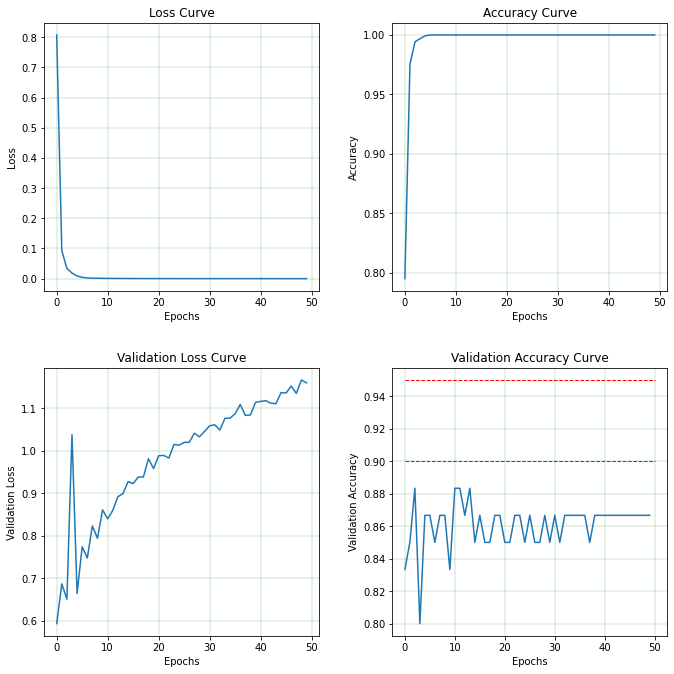

In [43]:
# plot loss and accuracy curves (disabled as well)
plot_loss(history)

In [44]:
show_diffs(model, x_test/255, y_test, p_test)

list of wrongly predicted images:
D: ./test\orange_79.jpg
D: ./test\orange_87.jpg
D: ./test\banana_86.jpg
D: ./test\banana_88.jpg
D: ./test\banana_91.jpg
D: ./test\mixed_23.jpg
D: ./test\mixed_24.jpg
D: ./test\mixed_25.jpg
Model scoring vs ground truth
D: ./test\apple_77.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_78.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_79.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_80.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_81.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_82.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_83.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_84.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_85.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_86.jpg, A: [1 0 0 0], P: [0.729  0.0  0.254  0.017  ]
D: ./test\apple_87.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_88.jpg, A: [1 0 0 0],

### Observation: 
With image augmentation, we greatly increased the dataset size. The average accuracy score increased to 87.5%. Interestingly, validation score starts low and begins climbing immediately. (This trend is persistent accross different iterations of this notebook.)

# Part C: No image augmentation, expanded model 

The expanded model is trained with the original dataset

In [45]:
# get list of training files
file_path_arr = get_files_in_dir(train_img_dir, image_types)

# show how many of each type we have
print('Files of each type used for training: ')
for key in file_path_arr:
    print(key, "->", len(file_path_arr[key]))
x_train, y_train, _ = read_files_into_array(file_path_arr,image_types,img_aug=False)
x_train = x_train.reshape(-1,IMG_MAX_SIZE,IMG_MAX_SIZE,3)
y_train = y_train.reshape(-1,4)
# get test file list

print('Files of each type used for testing: ')
file_path_arr_2 = get_files_in_dir(test_img_dir, image_types)
# show how many of each type we have
for key in file_path_arr_2:
    print(key, "->", len(file_path_arr_2[key]))
# generate x and y test data as well as the file paths
x_test, y_test, p_test = read_files_into_array(file_path_arr_2,image_types)
# reshape x and y test data
x_test = x_test.reshape(-1,IMG_MAX_SIZE,IMG_MAX_SIZE,3)
y_test = y_test.reshape(-1,4)# get list of training files

Files of each type used for training: 
apple -> 75
orange -> 72
banana -> 73
mixed -> 20
Files of each type used for testing: 
apple -> 19
orange -> 18
banana -> 18
mixed -> 5


In [46]:
#checking input and output shapes
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(240, 64, 64, 3)
(240, 4)
(60, 64, 64, 3)
(60, 4)


In [47]:
model = create_model_expanded()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)         

In [48]:
x_train, y_train = shuffle(x_train,y_train,random_state=9)

# train the model then run the test at each to see accuracy
history = model.fit(x=x_train/255, y=y_train, epochs=EPOCH_MAX, verbose=1, validation_data=(x_test/255,y_test))

Epoch 1/50
8/8 [==============================] - 1s 110ms/step - loss: 1.8682 - accuracy: 0.2333 - val_loss: 1.3554 - val_accuracy: 0.4167
Epoch 2/50
8/8 [==============================] - 1s 94ms/step - loss: 1.5655 - accuracy: 0.2958 - val_loss: 1.3324 - val_accuracy: 0.4500
Epoch 3/50
8/8 [==============================] - 1s 84ms/step - loss: 1.4988 - accuracy: 0.3417 - val_loss: 1.3056 - val_accuracy: 0.4833
Epoch 4/50
8/8 [==============================] - 1s 88ms/step - loss: 1.4688 - accuracy: 0.3167 - val_loss: 1.2749 - val_accuracy: 0.3333
Epoch 5/50
8/8 [==============================] - 1s 91ms/step - loss: 1.2966 - accuracy: 0.4458 - val_loss: 1.2157 - val_accuracy: 0.5833
Epoch 6/50
8/8 [==============================] - 1s 92ms/step - loss: 1.1151 - accuracy: 0.5417 - val_loss: 1.1673 - val_accuracy: 0.7333
Epoch 7/50
8/8 [==============================] - 1s 97ms/step - loss: 0.9580 - accuracy: 0.6208 - val_loss: 1.1305 - val_accuracy: 0.7500
Epoch 8/50
8/8 [==========

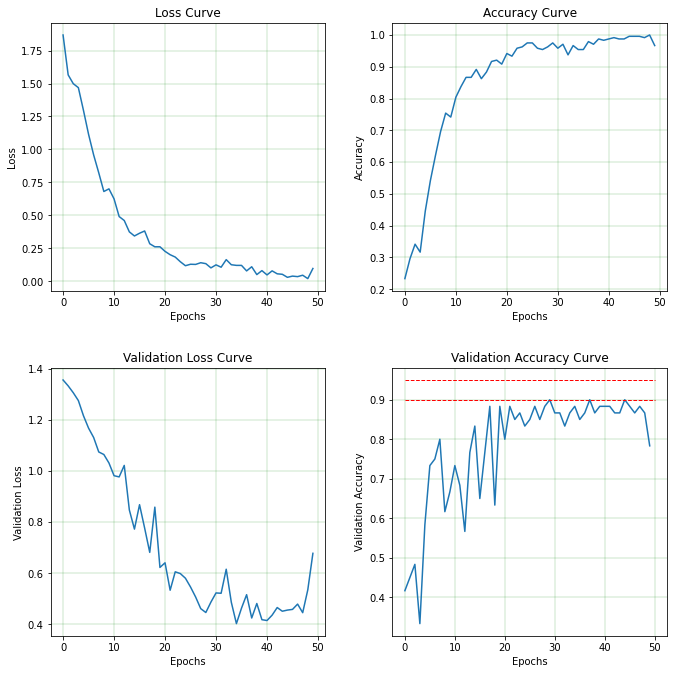

In [49]:
# plot loss and accuracy curves (disabled as well)
plot_loss(history)

In [50]:
show_diffs(model, x_test/255, y_test, p_test)

list of wrongly predicted images:
D: ./test\banana_83.jpg
D: ./test\banana_85.jpg
D: ./test\banana_86.jpg
D: ./test\banana_87.jpg
D: ./test\banana_88.jpg
D: ./test\banana_89.jpg
D: ./test\banana_91.jpg
D: ./test\banana_94.jpg
D: ./test\mixed_21.jpg
D: ./test\mixed_22.jpg
D: ./test\mixed_23.jpg
D: ./test\mixed_24.jpg
D: ./test\mixed_25.jpg
Model scoring vs ground truth
D: ./test\apple_77.jpg, A: [1 0 0 0], P: [0.975  0.014  0.007  0.004  ]
D: ./test\apple_78.jpg, A: [1 0 0 0], P: [0.986  0.008  0.003  0.003  ]
D: ./test\apple_79.jpg, A: [1 0 0 0], P: [0.994  0.004  0.001  0.001  ]
D: ./test\apple_80.jpg, A: [1 0 0 0], P: [0.995  0.003  0.001  0.001  ]
D: ./test\apple_81.jpg, A: [1 0 0 0], P: [0.989  0.007  0.002  0.002  ]
D: ./test\apple_82.jpg, A: [1 0 0 0], P: [0.99  0.006  0.002  0.002  ]
D: ./test\apple_83.jpg, A: [1 0 0 0], P: [0.989  0.007  0.002  0.002  ]
D: ./test\apple_84.jpg, A: [1 0 0 0], P: [0.958  0.025  0.009  0.008  ]
D: ./test\apple_85.jpg, A: [1 0 0 0], P: [0.94  0.037 

### Observation: 
Using the original dataset and expanded model, the validation accuracy score on average did not improve. However, there are times where validation accuracy score reached 90%. Increased model size allows more features to be learnt, potentially increase prediction score. 

# Part D: Image augmentation and expansion of prediction model

Combining expanded model and image dataset augmentation

In [51]:
# list of offending images
#skip_img_names = ["banana_35.jpg","banana_61.jpg"]
skip_img_names = ["apple_11","apple_20","apple_36","apple_39",
                  "banana_35","banana_61",
                  "mixed_2","mixed_20",
                  "orange_11","orange_13","orange_35","orange_42"]

# remove offending images
for skip_name in skip_img_names:
     remove_from_dictionary(file_path_arr,skip_name)

# get list of training files
file_path_arr = get_files_in_dir(train_img_dir, image_types)
print('Files of each type used for training: ')
for key in file_path_arr:
    print(key, "->", len(file_path_arr[key]))
x_train, y_train, _ = read_files_into_array(file_path_arr,image_types,img_aug=True)
x_train = x_train.reshape(-1,IMG_MAX_SIZE,IMG_MAX_SIZE,3)
y_train = y_train.reshape(-1,4)

# get test file list
file_path_arr_2 = get_files_in_dir(test_img_dir, image_types)
print('Files of each type used for testing: ')
for key in file_path_arr_2:
    print(key, "->", len(file_path_arr_2[key]))
# generate x and y test data as well as the file paths
x_test, y_test, p_test = read_files_into_array(file_path_arr_2,image_types)
# reshape x and y test data
x_test = x_test.reshape(-1,IMG_MAX_SIZE,IMG_MAX_SIZE,3)
y_test = y_test.reshape(-1,4)# get list of training files
file_path_arr = get_files_in_dir(train_img_dir, image_types)

Removed:  apple   2   ./train\apple_12.jpg
Removed:  apple   11   ./train\apple_21.jpg
Removed:  apple   26   ./train\apple_37.jpg
Removed:  apple   28   ./train\apple_4.jpg
Removed:  banana   25   ./train\banana_36.jpg
Removed:  banana   53   ./train\banana_62.jpg
Removed:  mixed   11   ./train\mixed_20.jpg
Removed:  mixed   11   ./train\mixed_3.jpg
Removed:  orange   2   ./train\orange_12.jpg
Removed:  orange   3   ./train\orange_14.jpg
Removed:  orange   26   ./train\orange_36.jpg
Removed:  orange   32   ./train\orange_43.jpg
Files of each type used for training: 
apple -> 75
orange -> 72
banana -> 73
mixed -> 20
Files of each type used for testing: 
apple -> 19
orange -> 18
banana -> 18
mixed -> 5


In [52]:
#checking input and output shapes
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3000, 64, 64, 3)
(3000, 4)
(60, 64, 64, 3)
(60, 4)


In [53]:
model = create_model_expanded()
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)         

In [54]:
x_train, y_train = shuffle(x_train,y_train,random_state=10)


stop_model_training_obj = stop_model_training_class()

# train the model then run the test at each to see accuracy
history = model.fit(x=x_train/255, y=y_train, epochs=EPOCH_MAX, validation_data=(x_test/255,y_test), callbacks=[stop_model_training_obj])

Epoch 1/50
94/94 [==============================] - 9s 94ms/step - loss: 1.1186 - accuracy: 0.5210 - val_loss: 1.0303 - val_accuracy: 0.8333
Epoch 2/50
94/94 [==============================] - 9s 92ms/step - loss: 0.4624 - accuracy: 0.8290 - val_loss: 0.5816 - val_accuracy: 0.8833
Epoch 3/50
94/94 [==============================] - 9s 98ms/step - loss: 0.2873 - accuracy: 0.9083 - val_loss: 0.3883 - val_accuracy: 0.9167
Epoch 4/50
94/94 [==============================] - 9s 93ms/step - loss: 0.2427 - accuracy: 0.9177 - val_loss: 0.3391 - val_accuracy: 0.9000
Epoch 5/50
94/94 [==============================] - 9s 94ms/step - loss: 0.1511 - accuracy: 0.9523 - val_loss: 0.3849 - val_accuracy: 0.9000
Epoch 6/50
94/94 [==============================] - 9s 94ms/step - loss: 0.1303 - accuracy: 0.9580 - val_loss: 0.4206 - val_accuracy: 0.9167
Epoch 7/50
94/94 [==============================] - 9s 94ms/step - loss: 0.1043 - accuracy: 0.9693 - val_loss: 0.3899 - val_accuracy: 0.9167
Epoch 8/50
94

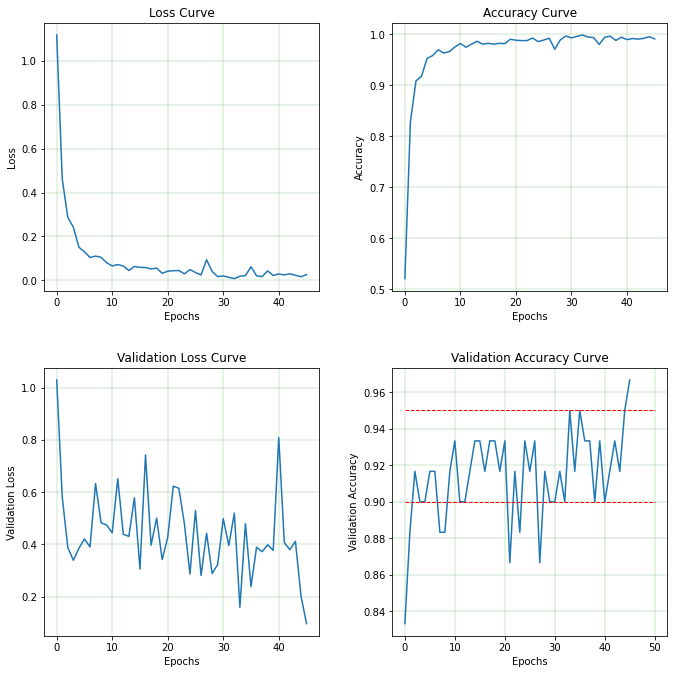

In [55]:
# plot loss and accuracy curves
plot_loss(history)

In [57]:
# show which were predicted incorrectly
show_diffs(model, x_test/255, y_test, p_test)

list of wrongly predicted images:
D: ./test\mixed_23.jpg
D: ./test\mixed_25.jpg
Model scoring vs ground truth
D: ./test\apple_77.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_78.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_79.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_80.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_81.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_82.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_83.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_84.jpg, A: [1 0 0 0], P: [0.925  0.004  0.043  0.028  ]
D: ./test\apple_85.jpg, A: [1 0 0 0], P: [0.782  0.0  0.212  0.006  ]
D: ./test\apple_86.jpg, A: [1 0 0 0], P: [0.983  0.001  0.005  0.011  ]
D: ./test\apple_87.jpg, A: [1 0 0 0], P: [0.997  0.0  0.001  0.001  ]
D: ./test\apple_88.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_89.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_90.jpg, A: [1 

### Observation: 
By combining our expanded model and expanded dataset, the average validation score has improved significantly to an average of 92.5%. \
We stopped the model when it has achieved validation accuracy 96.67% score, in order to maximise the accuracy of the model. As overfitting eventually begins to occur, a stopping point based on loss or accuracy might be a good idea.  

# Part E: (Experimental) Transfer learning with Resnet50
This is to test what happens when transfer learning is applied for this project. A existing trained CNN model(Resnet50) is downloaded and fitted for our dataset. Its first and last layers are not included, so that we can set our own input layer (fruits dataset and size) and output layer (4 classes) before training. The premise is that an existing model is already trained to recognise features. By tapping on existing weights/training, time is saved and retraining is only done to recognise the new dataset. 

In [60]:
#reference from: 
#https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/
from tensorflow.keras.models import Sequential
resnet_model = Sequential()

#input layer parameters is changed to match our model(32,32)
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(IMG_MAX_SIZE,IMG_MAX_SIZE,3),
                   pooling='avg',classes=4,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

#new output layer is added to fit our one-hot encoding(4 classes)
resnet_model.add(pretrained_model)
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(units=512, activation='relu'))
resnet_model.add(tf.keras.layers.Dense(units=4, activation='softmax'))
resnet_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 2052      
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
_________________________________________________________________


In [61]:
resnet_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [62]:
#checking input and output shapes
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3000, 64, 64, 3)
(3000, 4)
(60, 64, 64, 3)
(60, 4)


In [63]:
history = resnet_model.fit(x=x_train/255, y=y_train, epochs=EPOCH_MAX, verbose=1, validation_data=(x_test/255,y_test))

Epoch 1/50
94/94 [==============================] - 17s 182ms/step - loss: 1.1914 - accuracy: 0.4627 - val_loss: 1.0284 - val_accuracy: 0.5333
Epoch 2/50
94/94 [==============================] - 16s 168ms/step - loss: 0.9718 - accuracy: 0.5877 - val_loss: 1.0215 - val_accuracy: 0.6000
Epoch 3/50
94/94 [==============================] - 16s 167ms/step - loss: 0.8472 - accuracy: 0.6677 - val_loss: 0.8064 - val_accuracy: 0.6500
Epoch 4/50
94/94 [==============================] - 16s 168ms/step - loss: 0.8129 - accuracy: 0.6723 - val_loss: 0.8004 - val_accuracy: 0.6333
Epoch 5/50
94/94 [==============================] - 16s 172ms/step - loss: 0.7098 - accuracy: 0.7243 - val_loss: 0.8342 - val_accuracy: 0.6667
Epoch 6/50
94/94 [==============================] - 15s 159ms/step - loss: 0.6488 - accuracy: 0.7473 - val_loss: 0.8126 - val_accuracy: 0.7167
Epoch 7/50
94/94 [==============================] - 15s 164ms/step - loss: 0.6087 - accuracy: 0.7750 - val_loss: 0.7660 - val_accuracy: 0.7333

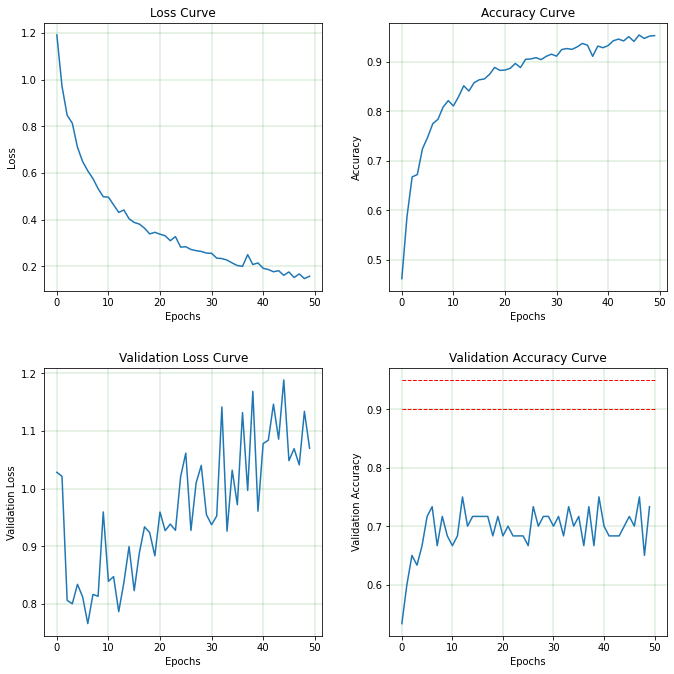

In [64]:
# plot loss and accuracy curves
plot_loss(history)

In [66]:
show_diffs(resnet_model, x_test/255, y_test, p_test)

list of wrongly predicted images:
D: ./test\apple_85.jpg
D: ./test\apple_92.jpg
D: ./test\apple_93.jpg
D: ./test\apple_94.jpg
D: ./test\apple_95.jpg
D: ./test\orange_77.jpg
D: ./test\orange_78.jpg
D: ./test\orange_81.jpg
D: ./test\orange_85.jpg
D: ./test\orange_86.jpg
D: ./test\orange_91.jpg
D: ./test\orange_92.jpg
D: ./test\banana_87.jpg
D: ./test\banana_91.jpg
D: ./test\mixed_21.jpg
D: ./test\mixed_23.jpg
D: ./test\mixed_24.jpg
D: ./test\mixed_25.jpg
Model scoring vs ground truth
D: ./test\apple_77.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_78.jpg, A: [1 0 0 0], P: [0.777  0.223  0.0  0.0  ]
D: ./test\apple_79.jpg, A: [1 0 0 0], P: [0.904  0.003  0.094  0.0  ]
D: ./test\apple_80.jpg, A: [1 0 0 0], P: [0.933  0.067  0.0  0.0  ]
D: ./test\apple_81.jpg, A: [1 0 0 0], P: [0.961  0.039  0.0  0.0  ]
D: ./test\apple_82.jpg, A: [1 0 0 0], P: [1.0  0.0  0.0  0.0  ]
D: ./test\apple_83.jpg, A: [1 0 0 0], P: [0.529  0.41  0.005  0.055  ]
D: ./test\apple_84.jpg, A: [1 0 0 0], P:

### Observation: 
The accuracy score of the retrained resnet50 is lower than of our expanded model. Perhaps its existing trained layers and features are unsuitable for our dataset. 

# Learning points:
- From experimentation, adding a pooling layer after convolution layer greatly reduces the training time required(from 60-80s to 2s!)
- Poor dataset will negatively affect model training and prediction scores
    - Mislabelled data causes the model to learn the wrong features
    - Lack of data will affect the model's ability to learn. Less than 100 images each is considered too small of a dataset. 
- Increasing dataset through image augmentation improves the quantity of features that our model can learn
    - But larger dataset has to be supported by a larger learning model, in order to increase prediction capability.

 


In [67]:
# Save final model
model.save("./saved_models/final_model_"+"0.xxxx"+".h5")
# we manually changed the name of the saved model to 0.9667.h5
# Load model
# loaded_model = tf.keras.models.load_model("./saved_models/final_model.h5")

In [ ]:
# loaded_model.evaluate(x=x_test/255,y=y_test)